# Projekt - Uczenie maszynowe
## Autor: Miłosz Chodkowski
## UAM, Bioinformatyka IV rok
------
### Wczytanie
Projekt zakłada prostą klasyfikację sekwencji do kategorii LIGAND lub RECEPTOR.
Dane pochodzą z bazy danych ligandów i ich receptorów. Z tych baz pobrano numery akcesyjne sekwencji nukleotydowych. Następnie pobrano sekwencje nukleotydowe z numerami akcesyjnymi oraz użyto JOIN'a do złączenia odpowiednich rekordów. W kolejnym kroku przeprowadzono kilka operacji porządkowania danych (tidy data). W Wyniku otrzymano ramkę danych z sekwencjami nukleotydów, ich numerami id, nazwami oraz typami.

### Features
Każdą sekwencję scharakteryzowano odpowiednimi metodami takimi jak GC content, GC skew, molecular mass, ATCG abundance, Shannon Entropy, melting temperature. Dodatkowo dla każdej sekwencji zliczono wystepowanie każdego możliwego 5-mera.

### PCA
Z uwagi na to, że wiele featuer'ów jest od siebie zależnych (wykazała to macierz korelacji oraz proces tworzenia konkretnych cech) przeprowadzono PCA do redukcji wymiarowości, co w kilku przypadkach poprawiło wyniki.

### Metody
Do klasyfikacji poszczególnych sekwencji użyto algorytmów KNN, Logistic Regression, Vowpal Wabbit oraz prosta sieci neuronowa z kilkoma gęstymi warstwami. Funkcje aktywacji Relu, w warstwie wyjściowej Sigmoid.

### Dodatkowa klasyfikacja na więcej niż 2 klasy.
W oddzielnym notebooku dokonano proby stworzenia klasyfikatorow na wiecej niz 2 klasy. Zadanie nie zostalo dokonczone, wyniki w wielu przypadkach nie wygladają dobrze, natomiast sam proces jest bardzo ciekawy i warty omówienia.



In [2]:
# Pairs
import pandas as pd

In [3]:
df = pd.read_csv("human_lr_pair.txt", sep = "\s+")
df

,lr_pair,ligand_gene_symbol,receptor_gene_symbol,ligand_gene_id,receptor_gene_id,ligand_ensembl_protein_id,receptor_ensembl_protein_id,ligand_ensembl_gene_id,receptor_ensembl_gene_id,evidence
0,SEMA3F_PLXNA3,SEMA3F,PLXNA3,6405,55558,ENSP00000002829,ENSP00000358696,ENSG00000001617,ENSG00000130827,15721238
1,SEMA3F_PLXNA1,SEMA3F,PLXNA1,6405,5361,ENSP00000002829,ENSP00000377061,ENSG00000001617,ENSG00000114554,26156437
2,SEMA3F_NRP1,SEMA3F,NRP1,6405,8829,ENSP00000002829,ENSP00000265371,ENSG00000001617,ENSG00000099250,9883722
3,SEMA3F_NRP2,SEMA3F,NRP2,6405,8828,ENSP00000002829,ENSP00000353582,ENSG00000001617,ENSG00000118257,15721238
4,CX3CL1_CX3CR1,CX3CL1,CX3CR1,6376,1524,ENSP00000006053,ENSP00000351059,ENSG00000006210,ENSG00000168329,"10699158,24218476"
...,...,...,...,...,...,...,...,...,...,...
3393,CGA_GPR84,CGA,GPR84,1081,53831,ENSP00000482232,ENSP00000450310,ENSG00000135346,ENSG00000139572,32196115
3394,ASIP_MC1R,ASIP,MC1R,434,4157,ENSP00000454804,ENSP00000451605,ENSG00000101440,ENSG00000258839,12851328
3395,VEGFA_ITGB3,VEGFA,ITGB3,7422,3690,ENSP00000478570,ENSP00000452786,ENSG00000112715,ENSG00000259207,32196115
3396,APELA_APLNR,APELA,APLNR,100506013,187,ENSP00000484618,ENSP00000475344,ENSG00000248329,ENSG00000134817,28663440


In [4]:
pairs = pd.melt(df, id_vars=['ligand_ensembl_gene_id', 'receptor_ensembl_gene_id'], value_vars=['ligand_gene_symbol', 'receptor_gene_symbol'])
pairs["variable"] = ["LIGAND" if x == "ligand_gene_symbol" else "RECEPTOR" for x in pairs["variable"]]
values = []


for ind, row in pairs.iterrows():
    if row["variable"] == "LIGAND":
        values.append(row['ligand_ensembl_gene_id'])
    else:
        values.append(row['receptor_ensembl_gene_id'])

pairs['ID'] = values
pairs.rename(columns={"variable": "type", "value": "gene"}, inplace = True)
pairs = pairs.drop(columns=['ligand_ensembl_gene_id', 'receptor_ensembl_gene_id']).drop_duplicates()
pairs

,type,gene,ID
0,LIGAND,SEMA3F,ENSG00000001617
4,LIGAND,CX3CL1,ENSG00000006210
5,LIGAND,HEBP1,ENSG00000013583
9,LIGAND,DCN,ENSG00000011465
12,LIGAND,GRN,ENSG00000030582
...,...,...,...
6710,RECEPTOR,GPR75,ENSG00000119737
6711,RECEPTOR,VSIR,ENSG00000107738
6725,RECEPTOR,CD72,ENSG00000137101
6731,RECEPTOR,TRPM2,ENSG00000142185


In [5]:
ids = "\n".join([str(x) for x in pairs["ID"].dropna()])
with open("list_for_entrez.txt", "w+") as fh:
    fh.write(ids)

In [6]:
from Bio import SeqIO

seqs = [s for s in SeqIO.parse("mart_export.txt", "fasta")]
for s in seqs:
    s.id = s.id.split("|")[0]
    
raw_seqs = [str(s.seq).replace("N", "") for s in seqs]
ids = [str(s.id) for s in seqs]
seq_df = pd.DataFrame({"seq": raw_seqs, "ID": ids}).drop_duplicates()
seq_df

,seq,ID
0,ATGCGTCCCCACCTGTCGCCGCCGCTGCAGCAGCTACTACTGCCGG...,ENSG00000080293
1,ATGAACCGGGGAGTCCCTTTTAGGCACTTGCTTCTGGTGCTGCAAC...,ENSG00000010610
2,ATGGCTCCGATATCTCTGTCGTGGCTGCTCCGCTTGGCCACCTTCT...,ENSG00000006210
3,ATGGCCGCGGCCTCCTCCCCGCCCAGGGCCGAGAGGAAGCGCTGGG...,ENSG00000053918
4,ATGTCCCGCCGCTCTATGCTGCTTGCCTGGGCTCTCCCCAGCCTCC...,ENSG00000008438
...,...,...
7833,ATGCCTGTGCCCTGGTTCTTGCTGTCCTTGGCACTGGGCCGAAGCC...,ENSG00000163702
7834,ATGCTGGGCATCTGGACCCTCCTACCTCTGGTTCTTACGTCTGTTG...,ENSG00000026103
7835,CGCCCGACTGCAACTGCTGACCCTGCAGAGCTGGCTGCTGGACGCA...,ENSG00000163702
7836,ATGCCTGTGCCCTGGTTCTTGCTGTCCTTGGCACTGGGCCGAAGCC...,ENSG00000163702


In [7]:
final = pd.merge(pairs, seq_df, on="ID").drop_duplicates(["type", "gene"])
final = final.loc[final["seq"] != "Sequenceunavailable"]

In [8]:
import collections
import math
import itertools
from Bio.SeqUtils import MeltingTemp as mt
from Bio.SeqUtils import molecular_weight as mw

def gc(seq):
    try:
        return (seq.count("G") + seq.count("C")) / len(seq)
    except ZeroDivisionError:
        return 0

def skew(seq):
    g = seq.count("G")
    c = seq.count("C")
    try:
        return (c - g) / (g + c)
    except ZeroDivisionError:
        return 0

def kmer(seq, size): 
    mers = set(seq[x:x+size] for x in range(len(seq) - size + 1))
    return {x: seq.count(x) for x in mers}

def possible_kmers(alphabet, size):
    return itertools.product(alphabet, repeat = size)

def shannon(seq):
    m = len(seq)
    bases = collections.Counter([tmp_base for tmp_base in seq])
 
    shannon_entropy_value = 0
    for base in bases:
        # number of residues
        n_i = bases[base]
        # n_i (# residues type i) / M (# residues in column)
        p_i = n_i / float(m)
        entropy_i = p_i * (math.log(p_i, 2))
        shannon_entropy_value += entropy_i
 
    return shannon_entropy_value * -1

In [9]:
final["A"] = final["seq"].transform(lambda x: x.count("A"))
final["T"] = final["seq"].transform(lambda x: x.count("T"))
final["G"] = final["seq"].transform(lambda x: x.count("G"))
final["C"] = final["seq"].transform(lambda x: x.count("C"))
final["gc"] = final["seq"].transform(gc)
final["skew"] = final["seq"].transform(skew)
final["shannon"] = final["seq"].transform(shannon)
final["melting_temp"] = final["seq"].transform(lambda x: mt.Tm_GC(x, strict = False))
final["molecular_weight"] = final["seq"].transform(mw)
final = final.reset_index(drop = True)
final

,type,gene,ID,seq,A,T,G,C,gc,skew,shannon,melting_temp,molecular_weight
0,LIGAND,SEMA3F,ENSG00000001617,ATGCTTGTCGCCGGTCTTCTTCTCTGGGCTTCCCTACTGACCGGGG...,465,443,659,791,0.614928,0.091034,1.957701,84.612483,7.261061e+05
1,LIGAND,CX3CL1,ENSG00000006210,ATGGCTCCGATATCTCTGTCGTGGCTGCTCCGCTTGGCCACCTTCT...,230,205,363,396,0.635678,0.043478,1.944476,85.215194,3.684329e+05
2,LIGAND,HEBP1,ENSG00000013583,ATGTTGGGCATGATCAAGAACTCGCTGTTCGGAAGCGTAGAGACGT...,156,115,167,132,0.524561,-0.117057,1.985182,80.109278,1.770098e+05
3,LIGAND,DCN,ENSG00000011465,ATGAAGGCCACTATCATCCTCCTTCTGCTTGCACAAGTTTCCTGGG...,306,271,236,267,0.465741,0.061630,1.993915,78.194707,3.331997e+05
4,LIGAND,GRN,ENSG00000030582,ATGTGGACCCTGGTGAGCTGGGTGGCCTTAACAGCAGGGCTGGTGG...,305,351,548,578,0.631874,0.026643,1.947592,85.225038,5.498697e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1527,RECEPTOR,QRFPR,ENSG00000186867,ATGCAGGCGCTTAACATTACCCCGGAGCAGTTCTCTCGGCTGCTGC...,162,199,191,225,0.535393,0.081731,1.990273,80.833785,2.392361e+05
1528,RECEPTOR,GPR75,ENSG00000119737,ATGAACTCAACAGGCCACCTTCAGGATGCCCCCAATGCCACCTCGC...,383,434,335,471,0.496611,0.168734,1.988303,79.646266,4.984846e+05
1529,RECEPTOR,CD72,ENSG00000137101,ATGGCTGAGGCCATCACCTATGCAGATCTGAGGTTTGTGAAGGCTC...,287,223,297,273,0.527778,-0.042105,1.991719,80.738226,3.344641e+05
1530,RECEPTOR,TRPM2,ENSG00000142185,ATGGAGCCCTCAGCCCTGAGGAAAGCTGGCTCGGAGCAGGAGGAGG...,940,808,1371,1393,0.612589,0.007959,1.961486,84.638048,1.394392e+06


In [10]:
all_kmers = ["".join(x) for x in possible_kmers("ATGC", 5)]

d = {}

for mer in all_kmers:
    d[mer] = final["seq"].str.count(mer)
d

{'AAAAA': 0       1
 1       0
 2       0
 3       2
 4       0
        ..
 1527    0
 1528    0
 1529    2
 1530    2
 1531    0
 Name: seq, Length: 1532, dtype: int64,
 'AAAAT': 0       0
 1       0
 2       0
 3       5
 4       0
        ..
 1527    1
 1528    0
 1529    2
 1530    0
 1531    0
 Name: seq, Length: 1532, dtype: int64,
 'AAAAG': 0       1
 1       0
 2       2
 3       2
 4       0
        ..
 1527    1
 1528    4
 1529    1
 1530    3
 1531    1
 Name: seq, Length: 1532, dtype: int64,
 'AAAAC': 0       0
 1       0
 2       0
 3       2
 4       0
        ..
 1527    0
 1528    1
 1529    2
 1530    2
 1531    0
 Name: seq, Length: 1532, dtype: int64,
 'AAATA': 0       0
 1       0
 2       0
 3       1
 4       0
        ..
 1527    1
 1528    0
 1529    0
 1530    0
 1531    0
 Name: seq, Length: 1532, dtype: int64,
 'AAATT': 0       0
 1       0
 2       2
 3       1
 4       0
        ..
 1527    0
 1528    2
 1529    3
 1530    0
 1531    0
 Name: seq, Length: 

In [11]:
final = pd.concat([final, pd.DataFrame(d)], axis = 1)
final

,type,gene,ID,seq,A,T,G,C,gc,skew,...,CCCTG,CCCTC,CCCGA,CCCGT,CCCGG,CCCGC,CCCCA,CCCCT,CCCCG,CCCCC
0,LIGAND,SEMA3F,ENSG00000001617,ATGCTTGTCGCCGGTCTTCTTCTCTGGGCTTCCCTACTGACCGGGG...,465,443,659,791,0.614928,0.091034,...,5,6,1,2,7,5,11,2,6,3
1,LIGAND,CX3CL1,ENSG00000006210,ATGGCTCCGATATCTCTGTCGTGGCTGCTCCGCTTGGCCACCTTCT...,230,205,363,396,0.635678,0.043478,...,4,2,3,4,2,0,7,3,3,4
2,LIGAND,HEBP1,ENSG00000013583,ATGTTGGGCATGATCAAGAACTCGCTGTTCGGAAGCGTAGAGACGT...,156,115,167,132,0.524561,-0.117057,...,1,1,0,1,0,0,1,0,0,0
3,LIGAND,DCN,ENSG00000011465,ATGAAGGCCACTATCATCCTCCTTCTGCTTGCACAAGTTTCCTGGG...,306,271,236,267,0.465741,0.061630,...,1,1,0,0,1,0,0,2,0,1
4,LIGAND,GRN,ENSG00000030582,ATGTGGACCCTGGTGAGCTGGGTGGCCTTAACAGCAGGGCTGGTGG...,305,351,548,578,0.631874,0.026643,...,9,2,1,1,5,4,8,6,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1527,RECEPTOR,QRFPR,ENSG00000186867,ATGCAGGCGCTTAACATTACCCCGGAGCAGTTCTCTCGGCTGCTGC...,162,199,191,225,0.535393,0.081731,...,2,1,0,1,1,1,1,0,1,0
1528,RECEPTOR,GPR75,ENSG00000119737,ATGAACTCAACAGGCCACCTTCAGGATGCCCCCAATGCCACCTCGC...,383,434,335,471,0.496611,0.168734,...,7,1,0,1,1,0,3,3,0,4
1529,RECEPTOR,CD72,ENSG00000137101,ATGGCTGAGGCCATCACCTATGCAGATCTGAGGTTTGTGAAGGCTC...,287,223,297,273,0.527778,-0.042105,...,2,1,0,0,0,1,0,2,0,0
1530,RECEPTOR,TRPM2,ENSG00000142185,ATGGAGCCCTCAGCCCTGAGGAAAGCTGGCTCGGAGCAGGAGGAGG...,940,808,1371,1393,0.612589,0.007959,...,15,7,4,4,10,9,12,6,9,3


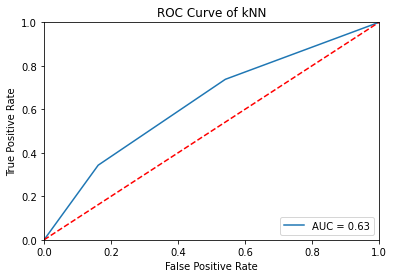

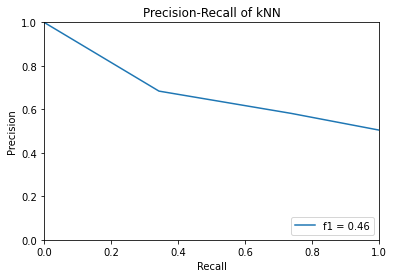

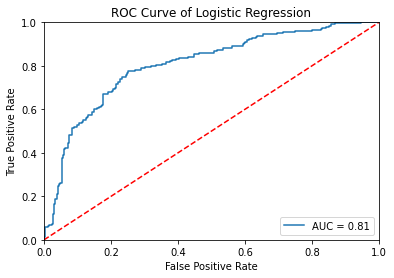

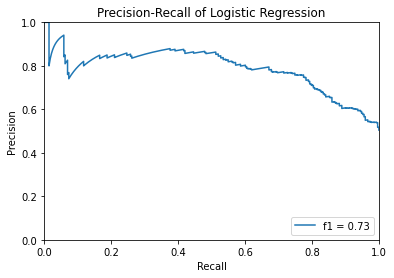

In [12]:
import vowpalwabbit
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import auc, f1_score
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt

X = final[["A", "T", "G", "C", "gc", "skew", "shannon", "melting_temp", "molecular_weight"] + all_kmers].transform(minmax_scale)
# Receptor 1, Ligand 0
Y = final["type"].transform(lambda x: 1 if x == "RECEPTOR" else 0)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.35)

# KNN
model = KNeighborsClassifier(2)
model.fit(X_train, Y_train)

predictions = model.predict(X_test)
probs = model.predict_proba(X_test)[:, 1]

fpr, tpr, threshold = roc_curve(Y_test, probs)
precision, recall, threshold = precision_recall_curve(Y_test, probs)
roc_auc = auc(fpr, tpr)
f1 = f1_score(Y_test, predictions)

plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

plt.plot(recall, precision, label = 'f1 = %0.2f' % f1)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision-Recall of kNN')
plt.show()


# Logistic Reg
reg = LogisticRegression(max_iter=3000)
reg.fit(X_train, Y_train)

preds = reg.predict(X_test)
probs = reg.predict_proba(X_test)[:, 1]

fpr, tpr, threshold = roc_curve(Y_test, probs)
roc_auc = auc(fpr, tpr)

precision, recall, threshold = precision_recall_curve(Y_test, probs)
f1 = f1_score(Y_test, preds)

plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Logistic Regression')
plt.show()

plt.plot(recall, precision, label = 'f1 = %0.2f' % f1)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision-Recall of Logistic Regression')
plt.show()

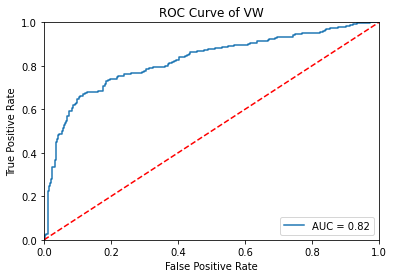

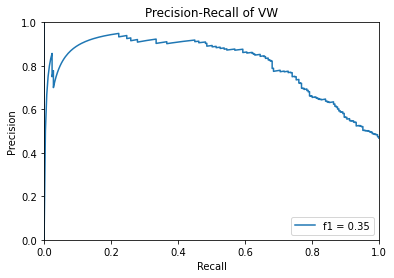

In [13]:
from vowpalwabbit.sklearn import VWClassifier
X = final[["A", "T", "G", "C", "gc", "skew", "shannon", "melting_temp", "molecular_weight"] + all_kmers].transform(minmax_scale)
# Receptor 1, Ligand 0
Y = final["type"].transform(lambda x: 1 if x == "RECEPTOR" else 0)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.35)

model = VWClassifier()
model.fit(X_train, Y_train)
# predict model
probs = model.predict_proba(X_test)[:, 1]

fpr, tpr, threshold = roc_curve(Y_test, probs)
precision, recall, threshold = precision_recall_curve(Y_test, probs)
roc_auc = auc(fpr, tpr)
f1 = f1_score(Y_test, predictions)

plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of VW')
plt.show()

plt.plot(recall, precision, label = 'f1 = %0.2f' % f1)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision-Recall of VW')
plt.show()


# Correlation

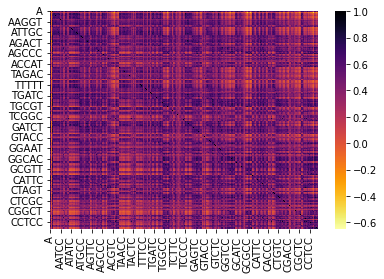

In [14]:
# Check for linear combinations
import seaborn as sn
import matplotlib.pyplot as plt

corrMatrix = final.corr()

sn.heatmap(corrMatrix, cmap = "inferno_r")
plt.show()
# Całkiem niezłe korelacje

# PCA

original shape:    (1532, 1033)
transformed shape: (1532, 13)


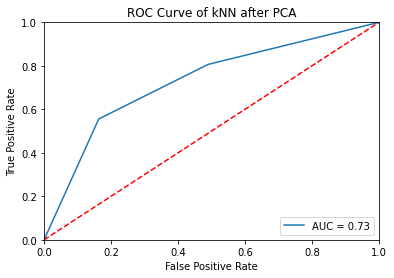

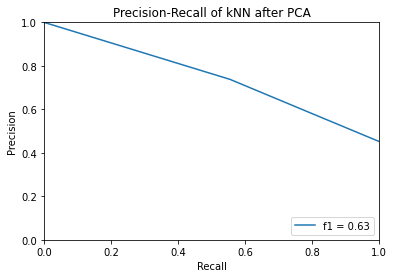

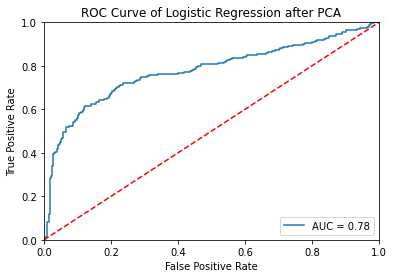

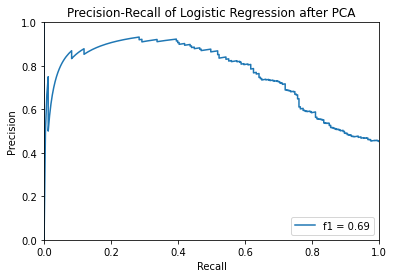

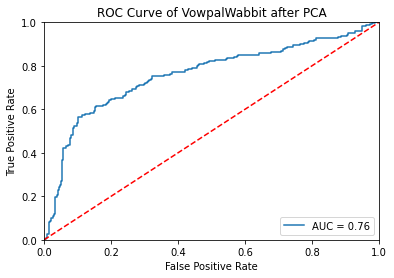

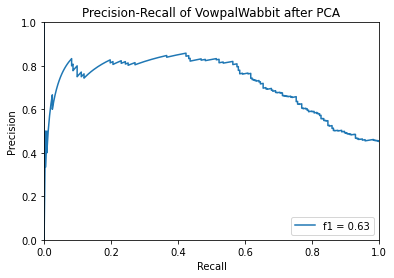

In [15]:
from sklearn.decomposition import PCA

X = final[["A", "T", "G", "C", "gc", "skew", "shannon", "melting_temp", "molecular_weight"] + all_kmers].transform(minmax_scale)
# Receptor 1, Ligand 0
Y = final["type"].transform(lambda x: 1 if x == "RECEPTOR" else 0)

pca = PCA(n_components=9 + 4)
pca.fit(X)
X_pca = pca.transform(X)

print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)


X_train, X_test, Y_train, Y_test = train_test_split(X_pca, Y, test_size = 0.35)


model = KNeighborsClassifier(2)
model.fit(X_train, Y_train)

predictions = model.predict(X_test)
probs = model.predict_proba(X_test)[:, 1]

fpr, tpr, threshold = roc_curve(Y_test, probs)
precision, recall, threshold = precision_recall_curve(Y_test, probs)
roc_auc = auc(fpr, tpr)
f1 = f1_score(Y_test, predictions)

plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN after PCA')
plt.show()

plt.plot(recall, precision, label = 'f1 = %0.2f' % f1)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision-Recall of kNN after PCA')
plt.show()


# Logistic Reg
reg = LogisticRegression(max_iter=3000)
reg.fit(X_train, Y_train)

preds = reg.predict(X_test)
probs = reg.predict_proba(X_test)[:, 1]

fpr, tpr, threshold = roc_curve(Y_test, probs)
roc_auc = auc(fpr, tpr)

precision, recall, threshold = precision_recall_curve(Y_test, probs)
f1 = f1_score(Y_test, preds)

plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Logistic Regression after PCA')
plt.show()

plt.plot(recall, precision, label = 'f1 = %0.2f' % f1)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision-Recall of Logistic Regression after PCA')
plt.show()


model = VWClassifier()
model.fit(X_train, Y_train)
    # predict model
probs = model.predict_proba(X_test)[:, 1]

fpr, tpr, threshold = roc_curve(Y_test, probs)
precision, recall, threshold = precision_recall_curve(Y_test, probs)
roc_auc = auc(fpr, tpr)
f1 = f1_score(Y_test, predictions)

plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of VowpalWabbit after PCA')
plt.show()

plt.plot(recall, precision, label = 'f1 = %0.2f' % f1)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision-Recall of VowpalWabbit after PCA')
plt.show()

# KERAS

In [16]:
# Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

X = final[["A", "T", "G", "C", "gc", "skew", "shannon", "melting_temp", "molecular_weight"] + all_kmers].transform(minmax_scale)
# Receptor 1, Ligand 0
Y = final["type"].transform(lambda x: 1 if x == "RECEPTOR" else 0)

pca = PCA(n_components=9 + 4**2)
pca.fit(X)
X_pca = pca.transform(X)

print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X_pca, Y, test_size = 0.35)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)
model = Sequential()
model.add(Dense(25, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs=175, batch_size=X_train.shape[0])

2022-06-08 21:56:39.785195: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-08 21:56:39.785359: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


original shape:    (1532, 1033)
transformed shape: (1532, 25)


2022-06-08 21:56:45.970398: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-08 21:56:45.970429: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-08 21:56:45.970450: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Thinkpad): /proc/driver/nvidia/version does not exist
2022-06-08 21:56:45.972171: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/175
1/1 [==============================] - 1s 998ms/step - loss: 0.6850 - accuracy: 0.5126 - val_loss: 0.6828 - val_accuracy: 0.5251
Epoch 2/175
1/1 [==============================] - 0s 36ms/step - loss: 0.6830 - accuracy: 0.5126 - val_loss: 0.6811 - val_accuracy: 0.5251
Epoch 3/175
1/1 [==============================] - 0s 33ms/step - loss: 0.6809 - accuracy: 0.5136 - val_loss: 0.6796 - val_accuracy: 0.5251
Epoch 4/175
1/1 [==============================] - 0s 34ms/step - loss: 0.6789 - accuracy: 0.5196 - val_loss: 0.6781 - val_accuracy: 0.5289
Epoch 5/175
1/1 [==============================] - 0s 38ms/step - loss: 0.6769 - accuracy: 0.5216 - val_loss: 0.6767 - val_accuracy: 0.5289
Epoch 6/175
1/1 [==============================] - 0s 36ms/step - loss: 0.6749 - accuracy: 0.5246 - val_loss: 0.6754 - val_accuracy: 0.5289
Epoch 7/175
1/1 [==============================] - 0s 33ms/step - loss: 0.6730 - accuracy: 0.5266 - val_loss: 0.6741 - val_accuracy: 0.5326
Epoch 8/175
1/1 [==

1/1 [==============================] - 0s 32ms/step - loss: 0.5650 - accuracy: 0.7578 - val_loss: 0.5985 - val_accuracy: 0.7132
Epoch 60/175
1/1 [==============================] - 0s 33ms/step - loss: 0.5629 - accuracy: 0.7588 - val_loss: 0.5972 - val_accuracy: 0.7188
Epoch 61/175
1/1 [==============================] - 0s 32ms/step - loss: 0.5609 - accuracy: 0.7598 - val_loss: 0.5960 - val_accuracy: 0.7244
Epoch 62/175
1/1 [==============================] - 0s 32ms/step - loss: 0.5588 - accuracy: 0.7628 - val_loss: 0.5948 - val_accuracy: 0.7281
Epoch 63/175
1/1 [==============================] - 0s 34ms/step - loss: 0.5566 - accuracy: 0.7648 - val_loss: 0.5935 - val_accuracy: 0.7300
Epoch 64/175
1/1 [==============================] - 0s 31ms/step - loss: 0.5544 - accuracy: 0.7648 - val_loss: 0.5922 - val_accuracy: 0.7300
Epoch 65/175
1/1 [==============================] - 0s 31ms/step - loss: 0.5521 - accuracy: 0.7658 - val_loss: 0.5909 - val_accuracy: 0.7318
Epoch 66/175
1/1 [========

1/1 [==============================] - 0s 32ms/step - loss: 0.4474 - accuracy: 0.8050 - val_loss: 0.5560 - val_accuracy: 0.7337
Epoch 118/175
1/1 [==============================] - 0s 32ms/step - loss: 0.4458 - accuracy: 0.8050 - val_loss: 0.5562 - val_accuracy: 0.7374
Epoch 119/175
1/1 [==============================] - 0s 34ms/step - loss: 0.4443 - accuracy: 0.8060 - val_loss: 0.5563 - val_accuracy: 0.7412
Epoch 120/175
1/1 [==============================] - 0s 34ms/step - loss: 0.4429 - accuracy: 0.8070 - val_loss: 0.5563 - val_accuracy: 0.7412
Epoch 121/175
1/1 [==============================] - 0s 32ms/step - loss: 0.4414 - accuracy: 0.8090 - val_loss: 0.5562 - val_accuracy: 0.7430
Epoch 122/175
1/1 [==============================] - 0s 32ms/step - loss: 0.4400 - accuracy: 0.8121 - val_loss: 0.5561 - val_accuracy: 0.7430
Epoch 123/175
1/1 [==============================] - 0s 34ms/step - loss: 0.4385 - accuracy: 0.8131 - val_loss: 0.5561 - val_accuracy: 0.7412
Epoch 124/175
1/1 [=

Epoch 175/175
1/1 [==============================] - 0s 35ms/step - loss: 0.3830 - accuracy: 0.8462 - val_loss: 0.5788 - val_accuracy: 0.7318


17/17 [==============================] - 0s 2ms/step
Accuracy := 73.18%


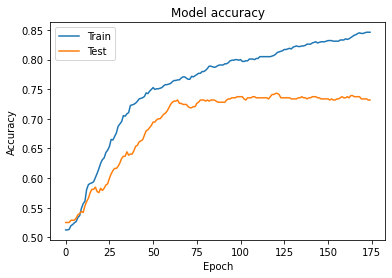

In [17]:
import numpy as np 
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)
# Converting predictions to label
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))
# Converting one hot encoded test label to label
test = list()
for i in range(len(Y_test)):
    test.append(np.argmax(Y_test[i]))
    
a = accuracy_score(pred, test)
print(f'Accuracy := {a * 100 :.2f}%')


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [18]:
from keras_visualizer import visualizer

visualizer(model, format='png', view=True)

Error: no "view" mailcap rules found for type "image/png"
